In [1]:
# Use Refinitiv data to Predict
# Stk price, rev, earnings data - act/est
# Futures price data - Bonds, Commodities, Stk indices

import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns


### Building a model to predict one asset price using the other asset prices. 
#### Eg: Predicting US Treasury bond price using the others. We have 3 bonds, 3 commodities, 3 Stocks

### 1. Importing the  Futures price data - Bonds, Commodities, Stk indices 

In [2]:

indexfutprice = pd.read_excel('/Users/nitinsinghal/Dropbox/DataScrumHackathon/RefinitvData/Futures1.xls')
futticker = pd.read_csv('/Users/nitinsinghal/Dropbox/DataScrumHackathon/RefinitvData/FutTicker.csv')


### 2. Create one dataframe for each index price

In [3]:
print(indexfutprice.head())

  Instrument                  Date  Open Price  High Price   Low Price  \
0       TYc1  2019-08-01T00:00:00Z  127.500000  128.812500  127.140625   
1       TYc1  2019-07-31T00:00:00Z  127.359375  127.703125  127.015625   
2       TYc1  2019-07-30T00:00:00Z  127.359375  127.546875  127.234375   
3       TYc1  2019-07-29T00:00:00Z  127.312500  127.500000  127.281250   
4       TYc1  2019-07-26T00:00:00Z  127.234375  127.375000  127.031250   

   Close Price  Accumulated Volume  Open Interest  
0   128.671875           3135151.0      3830231.0  
1   127.531250           2403170.0      3811064.0  
2   127.359375           1151527.0      3815758.0  
3   127.359375            867368.0      3807047.0  
4   127.312500           1002499.0      3824311.0  


### 3. Converting the Date value to Datetime type

In [4]:
indexfutprice['Date'] = pd.to_datetime(indexfutprice['Date'])
print(indexfutprice.dtypes)

Instrument                         object
Date                  datetime64[ns, UTC]
Open Price                        float64
High Price                        float64
Low Price                         float64
Close Price                       float64
Accumulated Volume                float64
Open Interest                     float64
dtype: object


### 4. Getting the price data for one instrument - Treasury bonds
#### Plotting the High, Low, Open, Close Price to see the variance between them
#### We can see the values are not widely different. Low variance between them

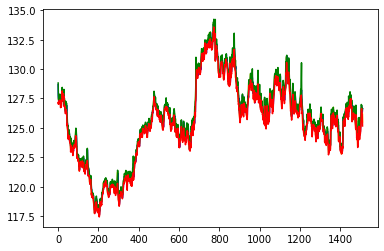

In [5]:
indxticklist = futticker['Instrument']
indxclosepricedf = indexfutprice[(indexfutprice['Instrument'] == indxticklist[0])]

plt.plot(indxclosepricedf['Open Price'], color='yellow')
plt.plot(indxclosepricedf['Close Price'], color='blue')
plt.plot(indxclosepricedf['High Price'], color='green')
plt.plot(indxclosepricedf['Low Price'], color='red')
plt.show()

### 5. Using the Close price for all instruments as that is a good reference point

In [6]:
indxclosepricedf = indxclosepricedf[['Date', 'Close Price']]
indxclosepricedf = indxclosepricedf.rename({'Close Price':indxticklist[0]}, axis='columns')


### 6. Plotting all the different asset prices to see visually the relationship between them

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a18489ac8>,
      dtype=object)

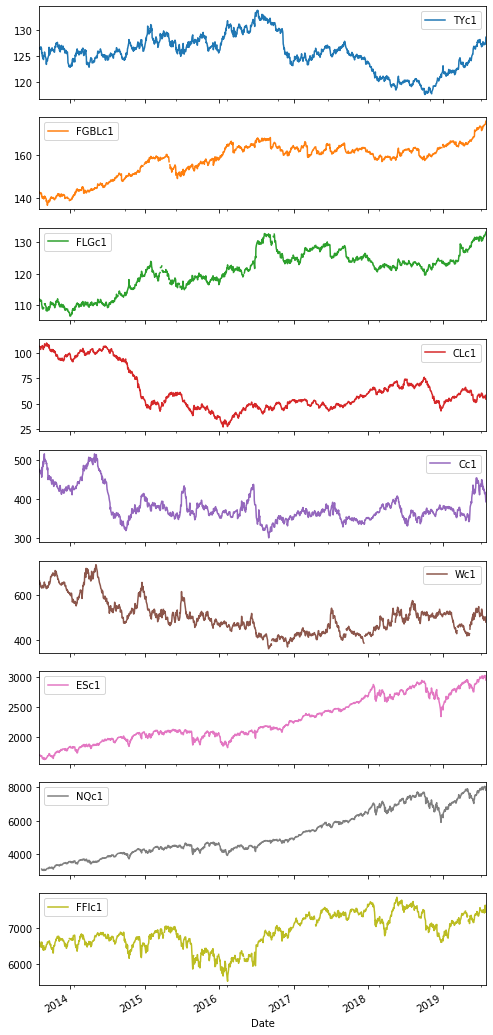

In [7]:
for x in range(1, len(indxticklist)):
    df = indexfutprice[(indexfutprice['Instrument'] == indxticklist[x])]
    df = df[['Date', 'Close Price']]
    df = df.rename({'Close Price':indxticklist[x]}, axis='columns')
    indxclosepricedf = pd.merge(indxclosepricedf, df, how='left', on='Date')

indxclosepricedf.plot(x='Date', subplots=True, figsize=(8,20))

### 7. Looking at the correlation between the different asset prices
#### One thing to keep in mind that ESc1-SP500 and NQc1-Nasdaq have a very strong correlation, so you can just use one of them

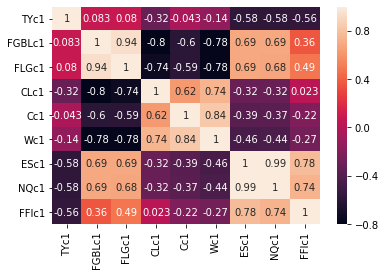

In [8]:
indxclosepricecorr = indxclosepricedf.corr(method='pearson')
sns.heatmap(indxclosepricecorr, annot=True) 

### 8. Splitting the dataset into train, test and validation sets. 
#### Using the last value for validation, removing it from the train/test set to prevent leak into model

In [9]:
print(len(indxclosepricedf.columns))
indxclosepricedf.fillna(0, inplace=True)
indxtrntstset = indxclosepricedf[:-1]
indxvalset = indxclosepricedf[-1:]

X = indxtrntstset.iloc[:, 2:len(indxtrntstset.columns)].values
y = indxtrntstset.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

10


### 9. Predict One asset price using others using the Random Forest Regressor using the Mean Squared Error estimator.
#### In this case US Treasury using Stocks, Commodities, and Other Bonds.
#### Also showing the difference between the predicted and the test values to check the variance
#### The hyperparameters were tuned using a gridserachcv model pipeline and other models were compared. Given at the end of the notebook

In [10]:
# Use RandomForest to explain results
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

rfreg = RandomForestRegressor(n_estimators=500, criterion='mse', min_samples_leaf=2, max_depth=14, 
                              min_samples_split=4, max_features='log2', random_state=42, n_jobs=-1)
rfreg.fit(X_train, y_train)
y_pred = rfreg.predict(X_test)

nfeat = rfreg.n_features_
featimp = rfreg.feature_importances_

mse = mean_squared_error(y_test , y_pred)
mae = mean_absolute_error(y_test , y_pred)
r2 = r2_score(y_test , y_pred)
testpreddiff = np.sort(y_pred-y_test, kind='quicksort')
testpreddiffpct = np.sort((y_pred-y_test)/y_pred, kind='quicksort')
print('mse:%.4f, mae:%.4f, r2:%.4f' %(mse, mae, r2))


mse:0.2607, mae:0.3371, r2:0.9760


### 10. Plot the predicted and test values to see visually the variance and check model goodness.

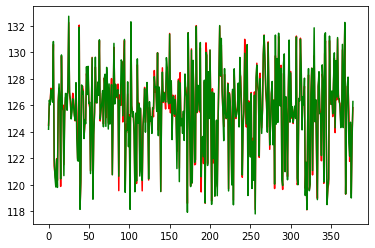

In [11]:
plt.plot(y_pred, color='red')
plt.plot(y_test, color='green')

### 11. Plotting the % difference between predicted values to see what is the range of the difference
#### We can see that majority of the predicted values are within +/- 0.05 of the test.

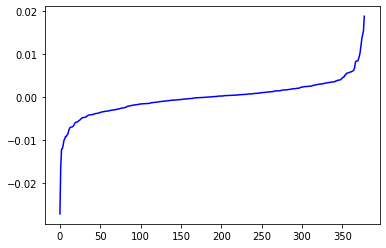

In [12]:
plt.plot(testpreddiffpct, color='blue')

### 12. Getting the model feature importance. Which feature was most important in predicting the values.
#### We can see that the stocks and commodities have higher importance.
#### However, SP500 and Nasdaq are both showing high importance as they are highly correlated.

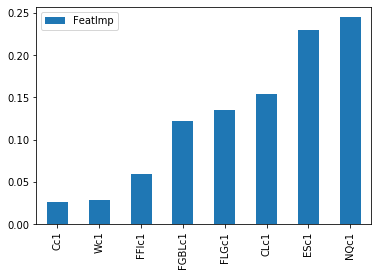

In [13]:
featimp = pd.DataFrame(featimp)
featimp = featimp.rename({0:'FeatImp'}, axis='columns')
featimp.index = indxclosepricedf.columns[2:]
featimp = featimp.sort_values(by=['FeatImp'])
featimp.plot(kind='bar')

### 13. Validate the model by predicting the price for the last day in the set. Compare it against the actual.
#### This value was already taken out of the train/test set. 
#### We can see that the predicted value is quite close to the actual with a difference of just -0.002.

In [14]:
# Validate model
X_val = indxvalset.iloc[:, 2:len(indxvalset.columns)].values
y_val = indxvalset.iloc[:, 1].values
y_valpred = rfreg.predict(X_val)

valpreddiff = (y_valpred-y_val)
valpreddiffpct = ((y_valpred-y_val)/y_valpred)
print('act:%.3f, pred:%.3f, diff:%.3f, diffpct:%.3f' % (y_val, y_valpred, valpreddiff, valpreddiffpct))

act:126.609, pred:126.397, diff:-0.212, diffpct:-0.002


### 14. GridSearchCV model to find the best model and the best hyperparameters.
#### Getting the best results from Random Forest Regressor vs Supprt Vector Regression and XGBoost.
#### Tuned best hyperparameters form this were used for the prediction, shown earlier in step 9.

Fitting the grid to estimator...

Estimator fitting: RandomForestRegressor

 Best training accuracy score: -0.24541

 Best grid params: {'rgr__criterion': 'mse', 'rgr__max_depth': 14, 'rgr__max_features': 'log2', 'rgr__min_samples_leaf': 2, 'rgr__min_samples_split': 4, 'rgr__n_estimators': 500}

 Test set accuracy for best params mse 0.2607 rmse 0.5106 mae 0.3371 r2 0.9760

Estimator fitting: SupportVectorRegression

 Best training accuracy score: -0.80998

 Best grid params: {'rgr__C': 5, 'rgr__gamma': 'scale', 'rgr__kernel': 'rbf'}

 Test set accuracy for best params mse 1.0176 rmse 1.0088 mae 0.6686 r2 0.9062

Estimator fitting: XGBoostRegressor

 Best training accuracy score: -0.31682

 Best grid params: {'rgr__learning_rate': 0.3, 'rgr__max_depth': 5, 'rgr__seed': 20}

 Test set accuracy for best params mse 0.2995 rmse 0.5473 mae 0.3765 r2 0.9724


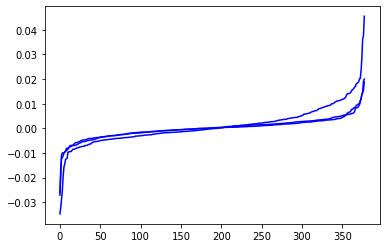

In [17]:
# Create the pipeline t0 run gridsearchcv for best estimator and hyperparameters
pipe_rf = Pipeline([('sclr', StandardScaler()),
               ('rgr', RandomForestRegressor(random_state=42))])

pipe_svr = Pipeline([('sclr', StandardScaler()),
                ('rgr', SVR())])

pipe_xgb = Pipeline([('rgr', xgb.XGBRegressor(objective ='reg:squarederror'))])

# Set grid search params
grid_params_rf = [{'rgr__n_estimators' : [500],
                   'rgr__criterion' : ['mse'], 
                   'rgr__min_samples_leaf' : [2,3,4], 
                   'rgr__max_depth' : [13,14,15],
                   'rgr__min_samples_split' : [4,5,6],
                   'rgr__max_features' : ['sqrt', 'log2']}]

grid_params_svr = [{'rgr__kernel' : ['rbf','sigmoid'],
                    'rgr__gamma' : ['scale'],
                    'rgr__C' : [3,4,5]}]

grid_params_xgb = [{'rgr__learning_rate' : [0.3, 0.4, 0.5],
                    'rgr__max_depth' : [3,4,5],
                    'rgr__seed' : [20, 20, 40]}]

# Create grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid=grid_params_rf,
                     scoring='neg_mean_squared_error',
                     iid=False,
                     cv=10,
                     n_jobs=-1)

gs_svr = GridSearchCV(estimator=pipe_svr,
                      param_grid=grid_params_svr,
                      scoring='neg_mean_squared_error',
                      iid=False,
                      cv=10,
                      n_jobs=-1)

gs_xgb = GridSearchCV(estimator=pipe_xgb,
                      param_grid=grid_params_xgb,
                      scoring='neg_mean_squared_error',
                      iid=False,
                      cv=10,
                      n_jobs=-1)

# List of grid pipelines
grids = [gs_rf, gs_svr, gs_xgb] 
# Grid dictionary for pipeline/estimator
grid_dict = {0:'RandomForestRegressor', 1:'SupportVectorRegression', 2: 'XGBoostRegressor'}

# Fit the grid
print('Fitting the grid to estimator...')
mse=0.0
mae=0.0
r2 = 0.0

for gsid,gs in enumerate(grids):
    print('\nEstimator fitting: %s' % grid_dict[gsid])
    gs.fit(X_train, y_train)
    print('\n Best training accuracy score: %.5f' % gs.best_score_)
    print('\n Best grid params: %s' % gs.best_params_)
    y_pred = gs.predict(X_test)
    mse = mean_squared_error(y_test , y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test , y_pred)
    r2 = r2_score(y_test , y_pred)
    testpreddiff = np.sort(y_pred-y_test, kind='quicksort')
    testpreddiffpct = np.sort((y_pred-y_test)/y_pred, kind='quicksort')
    print('\n Test set accuracy for best params mse %.4f rmse %.4f mae %.4f r2 %.4f' 
          % (mse, rmse, mae, r2))
    plt.plot(testpreddiffpct, color='blue')